In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from solvers import *

In [2]:
n = 100
m = 100
density = 0.1  # Probability of observing each entry

# seed
seed = int(time.time())

# Generate synthetic problem
X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                 seed - 1)  # seed-1 to avoid overlap with the gaussian initialization seed as they'd be the same otherwise

In [3]:
def compare_solvers(X_obs, X_true, u0, v0, mask, lambda_als=None, gd_params=None, plot=False, verbose=True, patience=10,
                    max_it=5000):
    """
    Compare the performance of Alternating Optimization (ALS), ALS with normalization and Gradient Descent.

    :param max_it:
    :param X_obs: Incomplete matrix (n x n), missing entries as zeros
    :param X_true: Ground truth matrix (n x n)
    :param u0: Initial guess for vector u (n,).
    :param v0: Initial guess for vector v (n,).
    :param mask: Binary mask of observed entries (n x n), dtype=bool
    :param lambda_als: Regularization strength for ALS and NormALS as a list
    :param gd_params: Gradient descent parameters as a list [lr, lambda_reg]
    :param plot: If True, plot residual curves
    """

    if lambda_als is None:
        lambda_als = [0.403, 1.5e-2]

    if verbose:
        print("=== Alternating Optimization (ALS) ===")
    start = time.time()
    u, v, it_als, res, hist = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=max_it,
        lambda_reg=lambda_als[0], verbose=False, track_residuals=plot,
        eps=1e-8, patience=patience
    )
    end = time.time()
    time_als = end - start
    ALS_sol = np.outer(u, v)
    observed_error_ALS = np.linalg.norm((ALS_sol - X_true) * mask, 'fro')
    full_error_ALS = np.linalg.norm(ALS_sol - X_true, 'fro')
    if verbose:
        print(
            f"ALS: Residual={res:.6f}, Observed Error={observed_error_ALS:.8f}, Full Error={full_error_ALS:.8f}, Iter={it_als}, Time={end - start:.4f}s")

    if verbose:
        print("\n=== ALS with Normalization (NormALS) ===")
    start = time.time()
    u, v, it_NormAls, res, hist2 = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=max_it,
        lambda_reg=lambda_als[1], norm_v=True, verbose=False, track_residuals=plot,
        eps=1e-8, patience=patience

    )
    end = time.time()
    time_NormALS = end - start
    NormALS_sol = np.outer(u, v)
    observed_error_NormALS = np.linalg.norm((NormALS_sol - X_true) * mask, 'fro')
    full_error_NormALS = np.linalg.norm(NormALS_sol - X_true, 'fro')
    if verbose:
        print(
            f"NormALS: Residual={res:.6f}, Observed Error={observed_error_NormALS:.8f}, Full Error={full_error_NormALS:.8f}, Iter={it_NormAls}, Time={end - start:.4f}s")

    if verbose:
        print("\n=== Gradient Descent (GD) ===")
    if gd_params is None:
        gd_params = [9.41e-04, 6.95e-05]
    lr = gd_params[0]
    lambda_gd = gd_params[1]
    start = time.time()
    u, v, it_gd, res, hist3 = gradient_descent_rank1(
        X_obs, mask, u_init=u0.copy(), v_init=v0.copy(),
        max_it=max_it, lr=lr, lambda_reg=lambda_gd,
        tol=1e-8, verbose=False, track_residuals=plot, patience=patience,
        gradient_clip=10.0
    )
    end = time.time()
    time_gd = end - start
    gd_sol = np.outer(u, v)
    observed_error_gd = np.linalg.norm((gd_sol - X_true) * mask, 'fro')
    full_error_gd = np.linalg.norm(gd_sol - X_true, 'fro')
    if verbose:
        print(
            f"GD: Residual={res:.6f}, Observed Error={observed_error_gd:.8f}, Full Error={full_error_gd:.8f}, Iter={it_gd}, Time={end - start:.4f}s")

    # Plot residuals if available
    if plot:
        plt.figure(figsize=(10, 6))
        if hist and hist['objective']:
            plt.plot(hist['objective'], label='ALS Observed Error')
        if hist2 and hist2['objective']:
            plt.plot(hist2['objective'], label='NormALS Observed Error')
        if hist3:
            plt.plot(hist3, label='GD Observed Error')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Error on Observed Entries')
        plt.title('Convergence Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        if hist and hist['residuals']:
            plt.plot(hist['residuals'], label='ALS Residuals')
        if hist2 and hist2['residuals']:
            plt.plot(hist2['residuals'], label='NormALS Residuals')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title('Residuals Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # group the results in a dictionary
    results = {
        'ALS': {
            'observed_error': observed_error_ALS,
            'full_error': full_error_ALS,
            'time': time_als,
            'iterations': it_als,
        },
        'NormALS': {
            'observed_error': observed_error_NormALS,
            'full_error': full_error_NormALS,
            'time': time_NormALS,
            'iterations': it_NormAls,
        },
        'GD': {
            'observed_error': observed_error_gd,
            'full_error': full_error_gd,
            'time': time_gd,
            'iterations': it_gd,
        }
    }
    return results


# Baseline using Truncated SVD with imputed values
print("\n=== Truncated SVD ===")
observed_error_svd, full_error_svd, time_svd = baseline_svd_numpy(X_true, X_obs, mask)
print(f"SVD: Observed Error={observed_error_svd:.6f}, Full Error={full_error_svd:.6f}, Time={time_svd:.4f}s")


=== Truncated SVD ===
SVD: Observed Error=27.064379, Full Error=93.140640, Time=0.0102s


=== Gaussian Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=1.687221, Observed Error=1.68722132, Full Error=12.45006075, Iter=103, Time=0.2929s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=10.993018, Observed Error=10.99301798, Full Error=129.21038156, Iter=10, Time=0.0281s

=== Gradient Descent (GD) ===
GD: Residual=147.940213, Observed Error=3.07015466, Full Error=18.95265563, Iter=464, Time=0.0345s


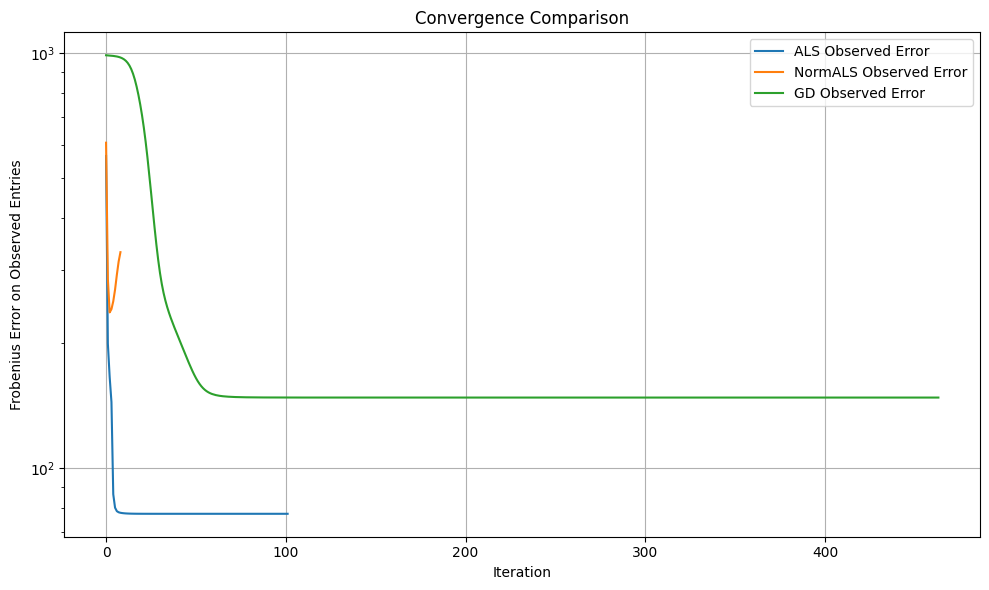

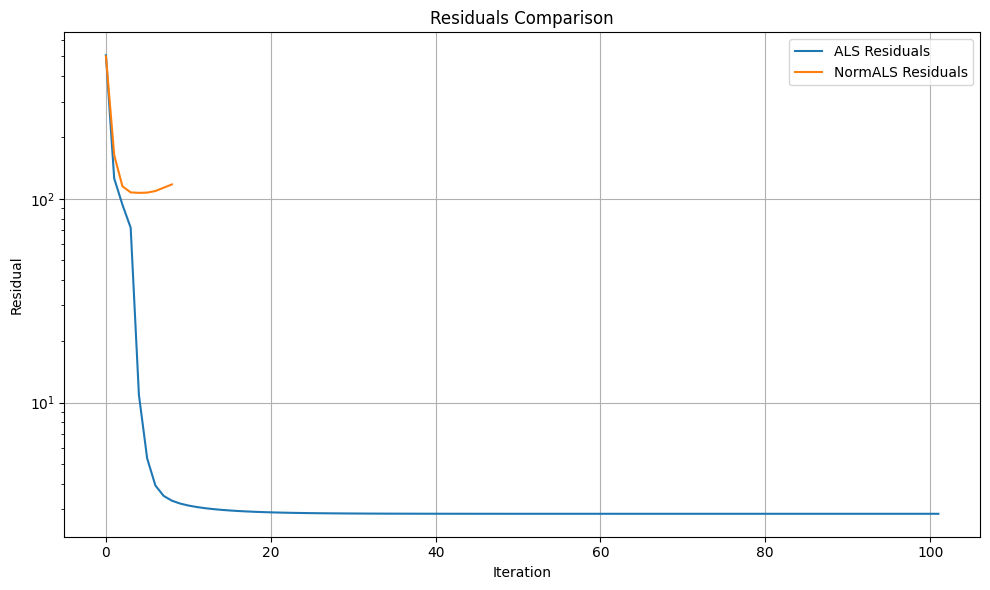

In [4]:
# Benchmark the different initialization strategies
print("=== Gaussian Initialization ===")
u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
# Benchmark the different solvers
gauss = compare_solvers(X_obs, X_true, u0_g.copy(), v0_g.copy(), mask, plot=True, gd_params=[9e-3, 7.94e-01],
                        max_it=5000, patience=3)


=== SVD Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=0.000000, Observed Error=0.00000026, Full Error=0.00000450, Iter=67, Time=0.1945s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=0.000000, Observed Error=0.00000004, Full Error=0.00000031, Iter=71, Time=0.2172s

=== Gradient Descent (GD) ===
GD: Residual=0.000003, Observed Error=0.00108691, Full Error=0.02419995, Iter=1456, Time=0.0848s


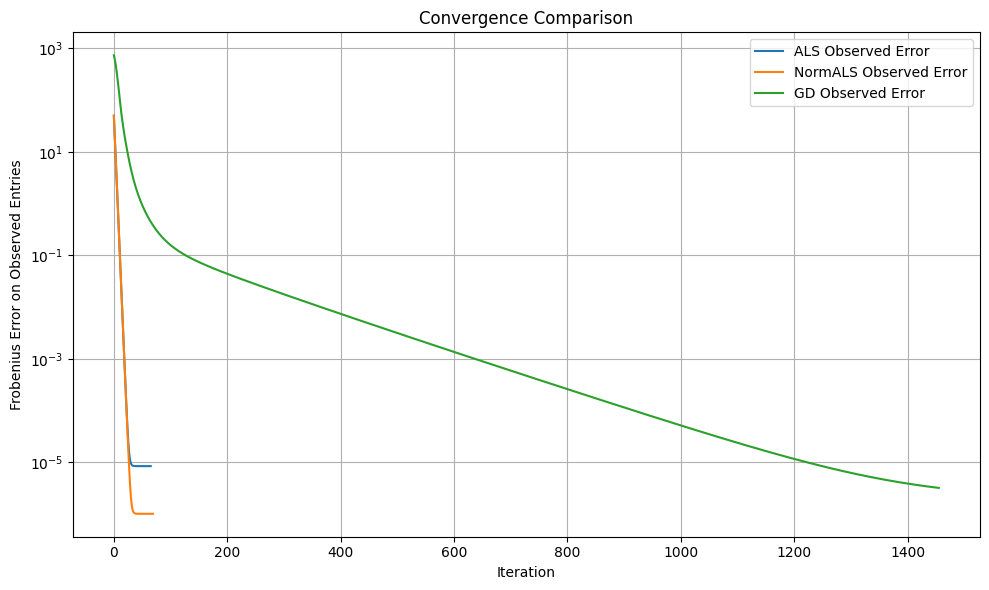

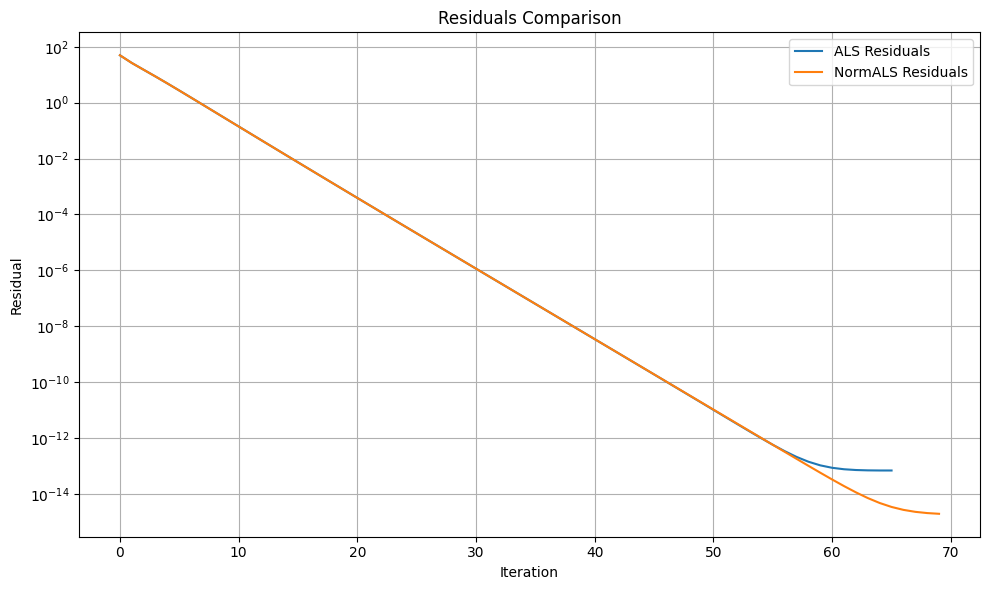

In [5]:
print("\n=== SVD Initialization ===")
u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
svd = compare_solvers(X_obs, X_true, u0_s.copy(), v0_s.copy(), mask, lambda_als=[1e-8, 1e-10], gd_params=[1e-02, 1e-08],
                      plot=True, max_it=5000, patience=3)


=== SVD + Noise Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=0.000001, Observed Error=0.00000070, Full Error=0.00001192, Iter=65, Time=0.1730s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=0.000000, Observed Error=0.00000004, Full Error=0.00000031, Iter=70, Time=0.2037s

=== Gradient Descent (GD) ===
GD: Residual=0.000003, Observed Error=0.00080300, Full Error=0.01787961, Iter=857, Time=0.0660s


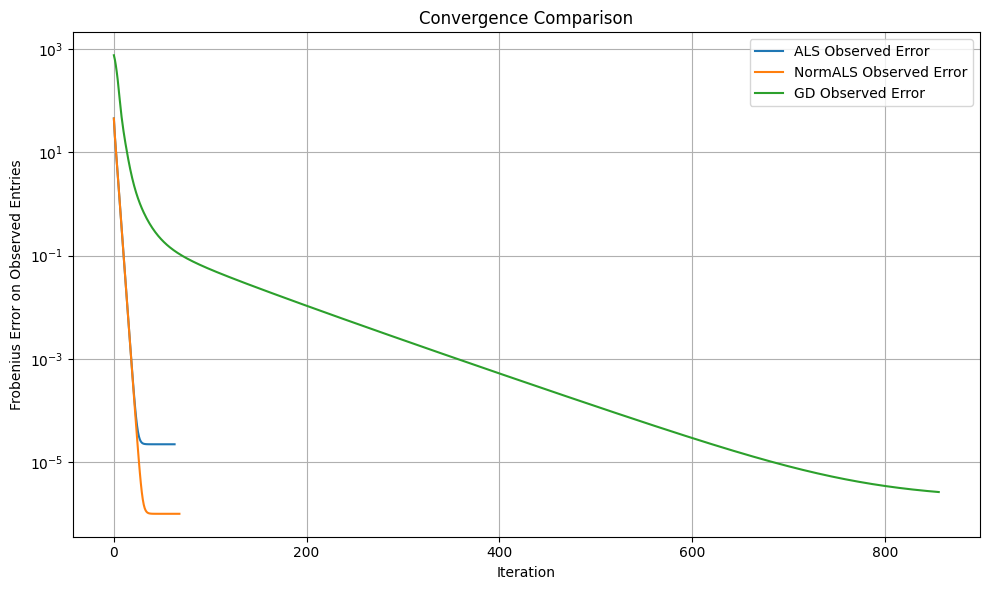

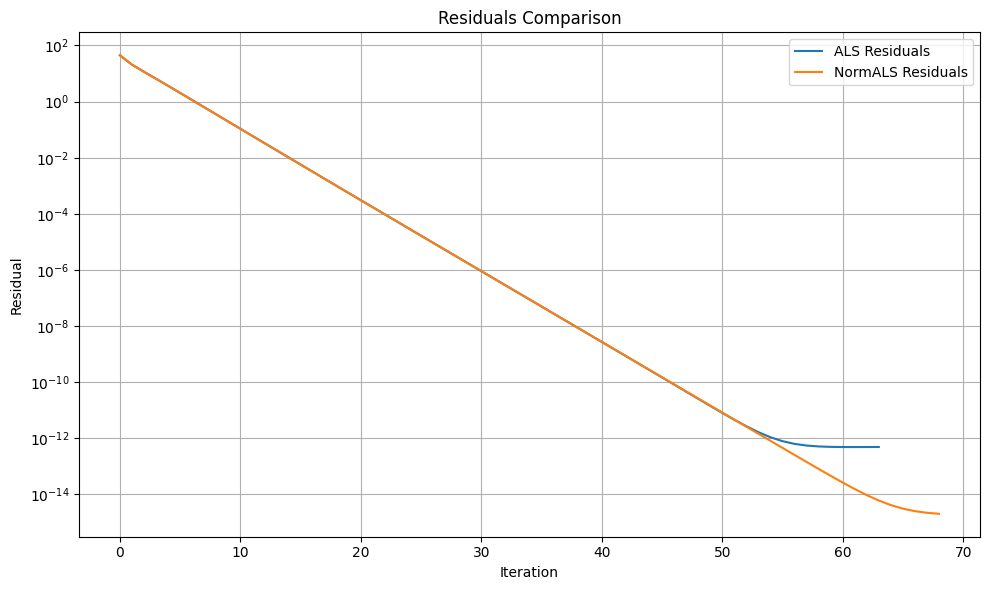

In [6]:
print("\n=== SVD + Noise Initialization ===")
u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
svd_n = compare_solvers(X_obs, X_true, u0_sn.copy(), v0_sn.copy(), mask, lambda_als=[3e-8, 1e-10],
                        gd_params=[1.78e-02, 1e-8], plot=True, max_it=5000, patience=3)


=== Mean Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=12.035521, Observed Error=12.03552090, Full Error=88.34539852, Iter=45, Time=0.1103s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=17.354674, Observed Error=17.35467383, Full Error=204.65694874, Iter=11, Time=0.0314s

=== Gradient Descent (GD) ===
GD: Residual=413.742917, Observed Error=20.33203848, Full Error=134.17495432, Iter=5000, Time=0.3023s


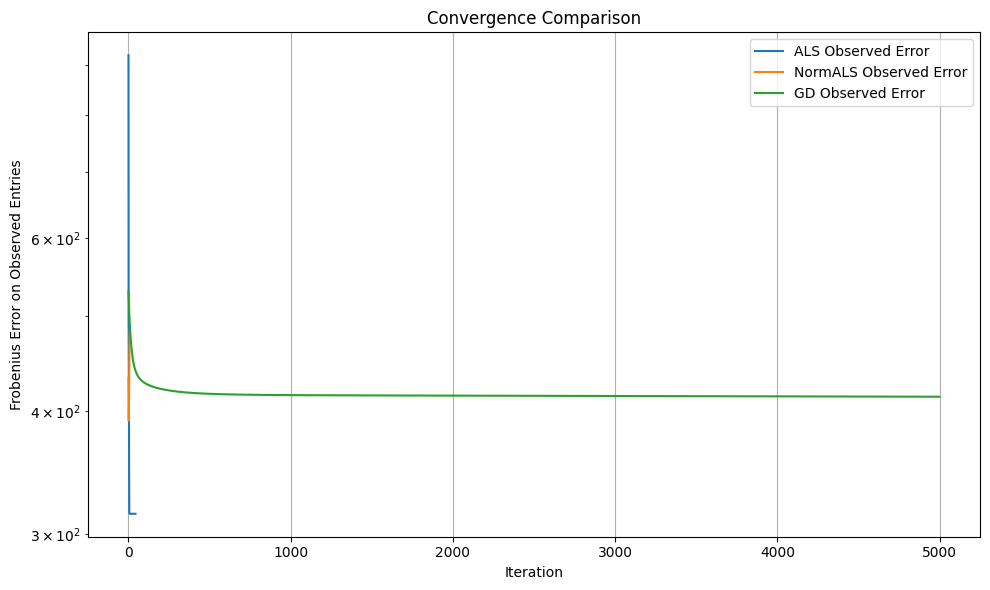

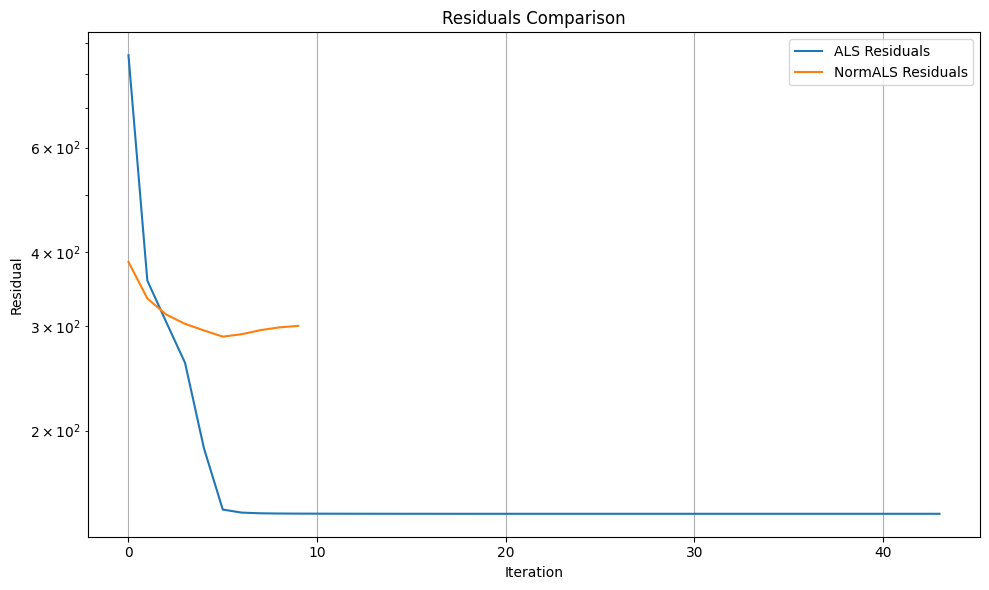

In [7]:
print("\n=== Mean Initialization ===")
u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
mean = compare_solvers(X_obs, X_true, u0_m.copy(), v0_m.copy(), mask, lambda_als=[1e-0, 5.80e-03],
                       gd_params=[1.78e-05, 5.62e-05], plot=True, max_it=5000, patience=3)

In [8]:
# compare the results of the different initializations and solvers in a table

# Create a DataFrame to store the results
results_ALS = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['ALS']['observed_error'],
        svd['ALS']['observed_error'],
        svd_n['ALS']['observed_error'],
        mean['ALS']['observed_error']
    ],
    'Full Error': [
        gauss['ALS']['full_error'],
        svd['ALS']['full_error'],
        svd_n['ALS']['full_error'],
        mean['ALS']['full_error']
    ],
    'Time': [
        gauss['ALS']['time'],
        svd['ALS']['time'],
        svd_n['ALS']['time'],
        mean['ALS']['time']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_ALS, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization (ALS) ===")
print(table_str)

results_NormALS = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['NormALS']['observed_error'],
        svd['NormALS']['observed_error'],
        svd_n['NormALS']['observed_error'],
        mean['NormALS']['observed_error']
    ],
    'Full Error': [
        gauss['NormALS']['full_error'],
        svd['NormALS']['full_error'],
        svd_n['NormALS']['full_error'],
        mean['NormALS']['full_error']
    ],
    'Time': [
        gauss['NormALS']['time'],
        svd['NormALS']['time'],
        svd_n['NormALS']['time'],
        mean['NormALS']['time']
    ]
})

# Convert the DataFrame to a string table
table_str = tabulate(results_NormALS, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization with Normalization (NormALS) ===")
print(table_str)

results_gd = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['GD']['observed_error'],
        svd['GD']['observed_error'],
        svd_n['GD']['observed_error'],
        mean['GD']['observed_error']
    ],
    'Full Error': [
        gauss['GD']['full_error'],
        svd['GD']['full_error'],
        svd_n['GD']['full_error'],
        mean['GD']['full_error']
    ],
    'Time': [
        gauss['GD']['time'],
        svd['GD']['time'],
        svd_n['GD']['time'],
        mean['GD']['time']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_gd, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Gradient Descent (GD) ===")
print(table_str)


=== Alternating Optimization (ALS) ===
+-------------+-----------------------+------------------------+---------------------+
|   Method    |    Observed Error     |       Full Error       |        Time         |
+-------------+-----------------------+------------------------+---------------------+
|  Gaussian   |  1.6872213242942067   |   12.450060745670601   | 0.29288291931152344 |
|     SVD     | 2.640715317961748e-07 | 4.504725490400819e-06  | 0.1944727897644043  |
| SVD + Noise | 7.002181391384701e-07 | 1.1921811240511448e-05 | 0.17299389839172363 |
|    Mean     |  12.035520897553825   |    88.3453985190085    | 0.11026287078857422 |
+-------------+-----------------------+------------------------+---------------------+
=== Alternating Optimization with Normalization (NormALS) ===
+-------------+-----------------------+-----------------------+----------------------+
|   Method    |    Observed Error     |      Full Error       |         Time         |
+-------------+--------------

# Benchmarking over 20 seeds

In [9]:
# Take the time to initialize the uv vectors for each method over 20 seeds

init_times = {
    'gaussian': [],
    'svd': [],
    'svd+noise': [],
    'mean': []
}

for seed in range(20):
    # Gaussian initialization
    start = time.time()
    u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
    end = time.time()
    init_times['gaussian'].append(end - start)

    # SVD initialization
    start = time.time()
    u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
    end = time.time()
    init_times['svd'].append(end - start)

    # SVD + Noise initialization
    start = time.time()
    u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
    end = time.time()
    init_times['svd+noise'].append(end - start)

    # Mean initialization
    start = time.time()
    u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
    end = time.time()
    init_times['mean'].append(end - start)

In [10]:
# Convert the initialization times to a DataFrame for better visualization and print the mean times
init_times_df = pd.DataFrame(init_times)
print("=== Initialization Times (mean over 20 seeds) ===")
print(tabulate(init_times_df.mean().reset_index(), headers=['Method', 'Time (s)'], tablefmt='pretty', showindex=False))

=== Initialization Times (mean over 20 seeds) ===
+-----------+----------------------+
|  Method   |       Time (s)       |
+-----------+----------------------+
| gaussian  |         0.0          |
|    svd    | 0.009543538093566895 |
| svd+noise | 0.009265220165252686 |
|   mean    | 0.002418363094329834 |
+-----------+----------------------+


In [11]:
# baseline using Truncated SVD with imputed values over 20 seeds
svd_observed_errors = []
svd_full_errors = []
for seed in range(20):
    X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                     seed)
    observed_error_svd, full_error_svd, time_svd = baseline_svd(X_true, X_obs, mask)
    svd_observed_errors.append(observed_error_svd)
    svd_full_errors.append(full_error_svd)

# Convert the results to a DataFrame for better visualization
svd_results = pd.DataFrame({
    'Observed Error': svd_observed_errors,
    'Full Error': svd_full_errors,
})
print("=== Truncated SVD Results (mean over 20 seeds) ===")
print(tabulate(svd_results.mean().reset_index(), headers=['Metric', 'Value'], tablefmt='pretty', showindex=False))


=== Truncated SVD Results (mean over 20 seeds) ===
+----------------+-------------------+
|     Metric     |       Value       |
+----------------+-------------------+
| Observed Error | 26.50398823215901 |
|   Full Error   | 92.24388400758002 |
+----------------+-------------------+


In [12]:
init_settings = {
    'gaussian': {
        'lambda_als': [0.403, 1.5e-2],
        'gd_params': [9e-3, 7.94e-01]
    },
    'svd': {
        'lambda_als': [1e-8, 1e-10],
        'gd_params': [1.78e-02, 1e-08]
    },
    'svd+noise': {
        'lambda_als': [3e-8, 1e-10],
        'gd_params': [1e-02, 1e-8]
    },
    'mean': {
        'lambda_als': [1e-0, 5.80e-03],
        'gd_params': [1.78e-05, 5.62e-05]
    }
}


def run_benchmark_for_seed(seed, density=0.1, m=100, n=100):
    """
    Run the benchmark for a given seed over the different solvers and initialization strategies.
    :param seed: Random seed for reproducibility
    :param density: Density of the observed entries in the matrix
    :param m: Number of rows in the matrix
    :param n: Number of columns in the matrix
    :return: Dictionary containing the results for each method
    """

    X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density, seed=seed - 1)
    results = {}

    svd_results = baseline_svd(X_true, X_obs, mask)
    results['Baseline SVD'] = {
        'Baseline SVD': {
            'observed_error': svd_results[0],
            'full_error': svd_results[1],
            'time': svd_results[2],
            'iterations': 1
        }
    }

    for strategy_key in ['gaussian', 'svd', 'svd+noise', 'mean']:
        pretty_name = strategy_key.replace('+', ' + ').capitalize()

        init_time = time.time()
        if strategy_key == 'svd+noise':
            u0, v0 = initialize_uv(X_obs, mask, strategy='svd', epsilon=1e-4, seed=seed)
        else:
            u0, v0 = initialize_uv(X_obs, mask, strategy=strategy_key, seed=seed)
        init_time = time.time() - init_time
        # Get strategy-specific parameters
        params = init_settings[strategy_key]
        lambda_als = params['lambda_als']
        gd_params = params['gd_params']

        results[pretty_name] = compare_solvers(X_obs, X_true, u0.copy(), v0.copy(), mask, lambda_als=lambda_als,
                                               gd_params=gd_params, plot=False, verbose=False, patience=3, max_it=5000)
        # Add the time needed for initialization
        for solver in results[pretty_name]:
            results[pretty_name][solver]['time'] += init_time
    return results


def summarize_solver_results(solver, accum_results):
    rows = []
    # Special case for Baseline SVD since it doesn't have an init method
    if solver == 'Baseline SVD':
        obs = np.mean(accum_results[solver][f'{solver}_obs'])
        full = np.mean(accum_results[solver][f'{solver}_full'])
        time = np.mean(accum_results[solver][f'{solver}_time'])
        rows.append({
            'Observed Error': obs,
            'Full Error': full,
            'Time': time
        })
        return pd.DataFrame(rows)
    for method in ['Gaussian', 'Svd', 'Svd + noise', 'Mean']:
        obs = np.mean(accum_results[method][f'{solver}_obs'])
        obs_err_std = np.std(accum_results[method][f'{solver}_obs'])
        full = np.mean(accum_results[method][f'{solver}_full'])
        full_err_std = np.std(accum_results[method][f'{solver}_full'])
        time = np.mean(accum_results[method][f'{solver}_time'])
        if f'{solver}_iterations' in accum_results[method]:
            iterations = np.mean(accum_results[method][f'{solver}_iterations'])
        else:
            iterations = 1  # Default to 1 if not available

        rows.append({
            'Method': method,
            'Observed Error': obs,
            'Observed Error Std': obs_err_std,
            'Full Error': full,
            'Full Error Std': full_err_std,
            'Time': time,
            'Iterations': iterations
        })
    return pd.DataFrame(rows)

In [13]:
from collections import defaultdict

# Structure: method -> solver -> list of errors
accum_results = defaultdict(lambda: defaultdict(list))

for seed in range(50):
    seed_results = run_benchmark_for_seed(seed + 1, density=0.1, m=m, n=n)
    for method, solvers in seed_results.items():
        for solver, vals in solvers.items():
            accum_results[method][f'{solver}_obs'].append(vals['observed_error'])
            accum_results[method][f'{solver}_full'].append(vals['full_error'])
            accum_results[method][f'{solver}_time'].append(vals['time'])
            accum_results[method][f'{solver}_iterations'].append(vals['iterations'])

# === PRINT TABLES ===
for solver in ['ALS', 'NormALS', 'GD', 'Baseline SVD']:
    print(f"=== {solver} ===")
    df = summarize_solver_results(solver, accum_results)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print()

=== ALS ===
+-------------+------------------------+------------------------+------------------------+-----------------------+---------------------+------------+
|   Method    |     Observed Error     |   Observed Error Std   |       Full Error       |    Full Error Std     |        Time         | Iterations |
+-------------+------------------------+------------------------+------------------------+-----------------------+---------------------+------------+
|  Gaussian   |   7.134349872987594    |   6.289917411002242    |   60.753558864441494   |   55.81036195988414   | 0.19716166973114013 |   65.94    |
|     Svd     | 1.9450842969732038e-07 | 9.437588959312738e-08  | 2.2450215681112184e-06 | 3.152138926336218e-06 | 0.16915727138519288 |   52.92    |
| Svd + noise | 5.833258363625658e-07  | 2.8481159440878867e-07 |  6.73618451762399e-06  | 9.47131397227715e-06  | 0.16212220668792723 |    51.3    |
|    Mean     |   7.2018569450173615   |   5.675167418259431    |   42.552763415268366  

In [14]:
accum_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for density in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f"Running benchmark for density={density}")
    for seed in range(50):
        seed_results = run_benchmark_for_seed(seed + 1, density, m=m, n=n)

        for method, solvers in seed_results.items():
            for solver, vals in solvers.items():
                accum_results[density][method][f'{solver}_obs'].append(vals['observed_error'])
                accum_results[density][method][f'{solver}_full'].append(vals['full_error'])
                accum_results[density][method][f'{solver}_time'].append(vals['time'])
                accum_results[density][method][f'{solver}_iterations'].append(vals['iterations'])

    # === PRINT TABLES ===
    for solver in ['ALS', 'NormALS', 'GD', 'Baseline SVD']:
        print(f"=== {solver} ===")
        df = summarize_solver_results(solver, accum_results[density])
        print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
        print()

Running benchmark for density=0.1
=== ALS ===
+-------------+------------------------+------------------------+------------------------+-----------------------+---------------------+------------+
|   Method    |     Observed Error     |   Observed Error Std   |       Full Error       |    Full Error Std     |        Time         | Iterations |
+-------------+------------------------+------------------------+------------------------+-----------------------+---------------------+------------+
|  Gaussian   |   7.134349872987594    |   6.289917411002242    |   60.753558864441494   |   55.81036195988414   | 0.25714210987091063 |   65.94    |
|     Svd     | 1.9450842969732038e-07 | 9.437588959312738e-08  | 2.2450215681112184e-06 | 3.152138926336218e-06 | 0.22169506072998046 |   52.92    |
| Svd + noise | 5.833258363625658e-07  | 2.8481159440878867e-07 |  6.73618451762399e-06  | 9.47131397227715e-06  | 0.21081872463226317 |    51.3    |
|    Mean     |   7.2018569450173615   |   5.675167418

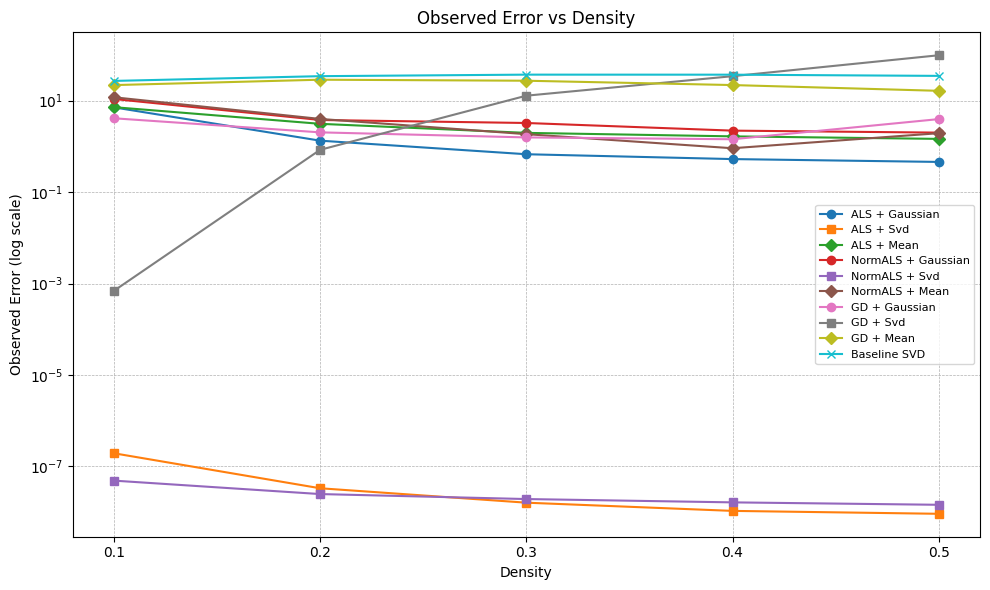

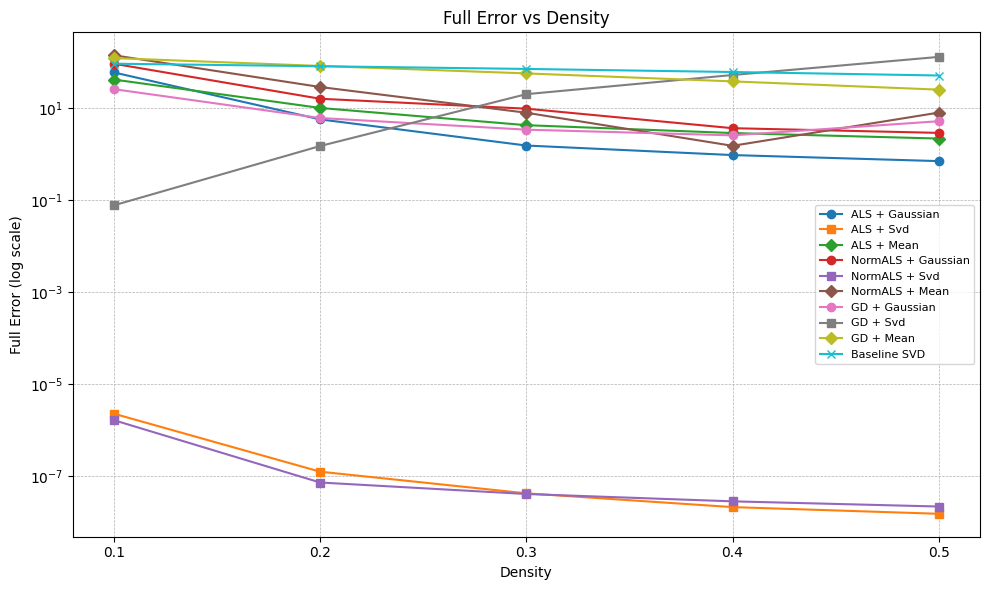

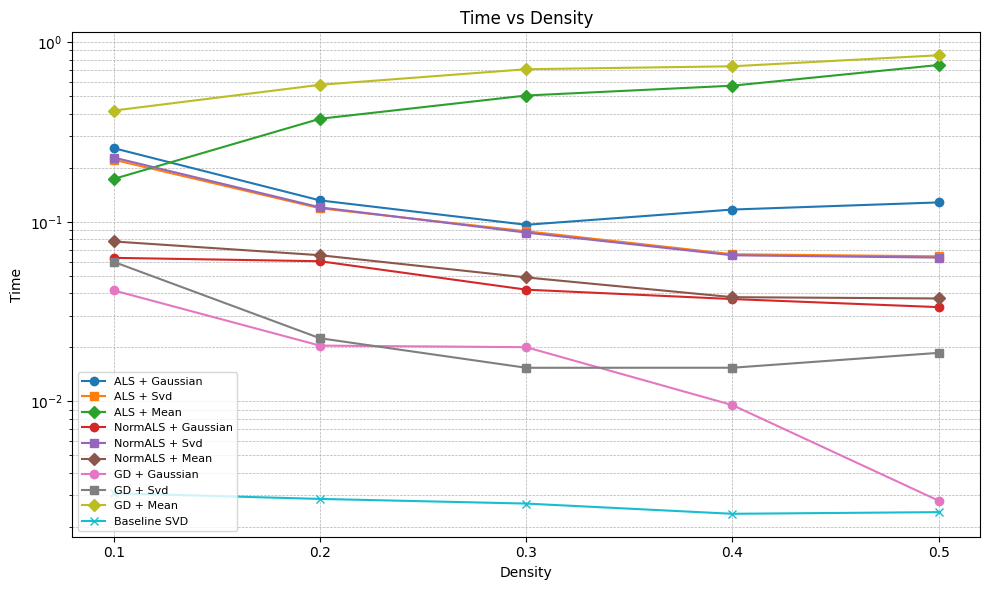

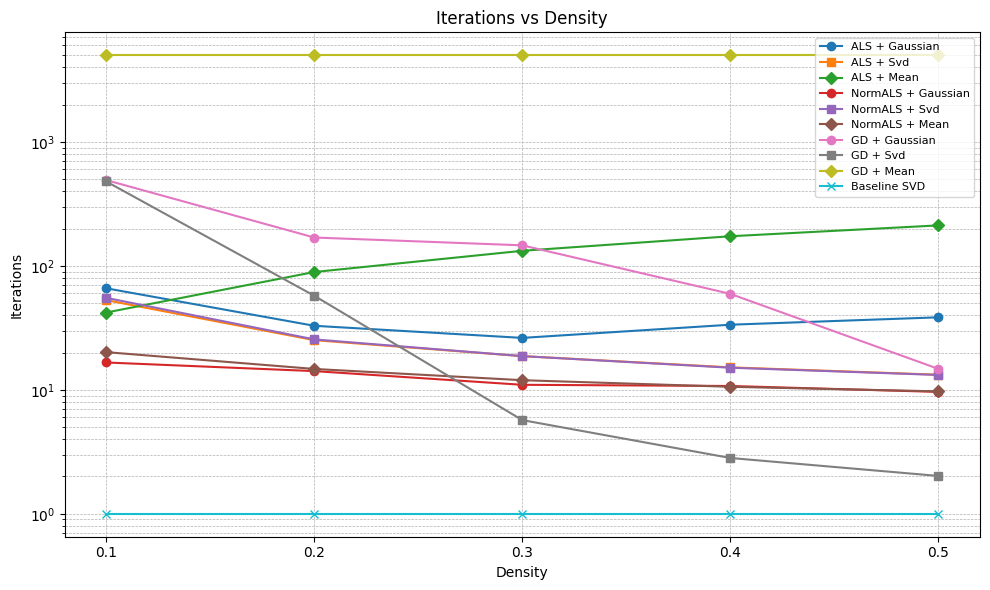

In [17]:
# Densities and categories
densities = [0.1, 0.2, 0.3, 0.4, 0.5]
solvers = ['ALS', 'NormALS', 'GD', 'Baseline SVD']  # Baseline SVD is included for completeness
methods = ['Gaussian', 'Svd', 'Mean']
metrics = {
    'Observed Error': 'obs',
    'Full Error': 'full',
    'Time': 'time',
    'Iterations': 'iterations',
}
# Defines distinct markers for plotting
method_markers = {
    'Gaussian': 'o',
    'Svd': 's',
    'Mean': 'D',
    'noise': '^',
}

# Loop over metrics and generate plots
for metric_name, suffix in metrics.items():
    # Collect metric values: key = "Solver + Method"
    metric_data = defaultdict(list)

    for density in densities:
        for solver in solvers:
            if solver == 'Baseline SVD':
                # Special case for Baseline SVD
                key = f"{solver}"
                try:
                    value = np.mean(accum_results[density][solver][f"{solver}_{suffix}"])
                    metric_data[key].append(value)
                except KeyError:
                    pass  # in case of missing data
            else:
                for method in methods:
                    key = f"{solver} + {method}"
                    try:
                        value = np.mean(accum_results[density][method][f"{solver}_{suffix}"])
                        metric_data[key].append(value)
                    except KeyError:
                        pass  # in case of missing data

    plt.figure(figsize=(10, 6))
    for label, values in metric_data.items():
        method = label.split(' + ')[-1]
        marker = method_markers.get(method, 'x')  # Default marker
        plt.plot(densities, values, marker=marker, label=label)

    plt.xlabel('Density')
    plt.ylabel(metric_name + (' (log scale)' if 'Error' in metric_name else ''))
    plt.title(f'{metric_name} vs Density')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(densities)
    plt.yscale('log')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{suffix}_vs_density.pdf')
    plt.show()